In [21]:
!pip install rawpy matplotlib
!pip install opencv-python


In [23]:
from astropy.io import fits
import numpy as np
import cv2
import rawpy

def openImage(fname):
  if str(fname)[-3:].lower() == 'nef':
    with open(fname, "rb") as f:
      rawimg = rawpy.imread(f)
      img = rawimg.postprocess()
  else:
    f = fits.open(fname)
    ph = f[0]
    img = ph.data

    if ph.header['BAYERPAT'] == 'RGGB':
        deb = cv2.cvtColor(img, cv2.COLOR_BAYER_BG2RGB)
        img = deb.astype(np.float32) / np.iinfo(deb.dtype).max
        img = (img * 255).astype(np.uint8)
  return img

In [3]:
import rawpy
from pathlib import Path

root = Path(r"D:\Astro\20220804\M31\light")
out_of_focus = root / "L_M31_0160_Bin1x1_300s__0C.fit"
in_focus = root / "L_M31_0121_Bin1x1_300s__0C.fit"
img = openImage(in_focus)



In [4]:
img.shape

(2822, 4144, 3)

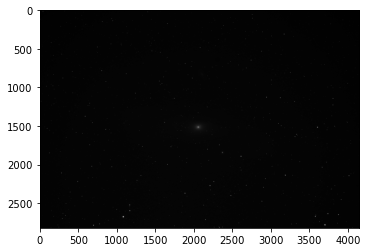

In [5]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

In [6]:
Bs = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(7,7))
Bmi = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(21,21))
Be = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(25,25))
Bmo = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(29,29))
d = (Bmo.shape[0] - Bmi.shape[0]) // 2
Bm = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(29,29))
Bm[d:d+Bmi.shape[0], d:d+Bmi.shape[0]] -= Bmi


In [7]:
K = cv2.morphologyEx(gray, cv2.MORPH_OPEN, Bs)
N = cv2.morphologyEx(cv2.morphologyEx(gray, cv2.MORPH_DILATE, Bm), cv2.MORPH_ERODE, Be)
print(K.shape, N.shape)

(2822, 4144) (2822, 4144)


In [8]:
R = K -np.minimum(K,N)

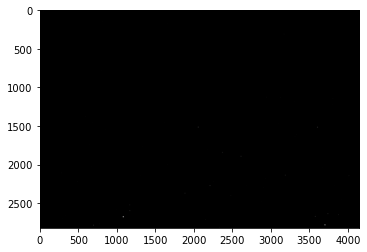

In [9]:
plt.imshow(R, cmap='gray')

In [10]:
numstars, labels, stats, centroids = cv2.connectedComponentsWithStats(R, 4, cv2.CV_16U, cv2.CCL_WU)

In [11]:
centroids

array([[2.07142146e+03, 1.40996423e+03],
       [3.22000000e+02, 2.50000000e+00],
       [3.93977273e+01, 1.50000000e+01],
       [1.39500000e+03, 2.40000000e+01],
       [2.74650000e+03, 5.70000000e+01],
       [2.74950000e+03, 1.05500000e+02],
       [9.28000000e+02, 1.12500000e+02],
       [5.62096774e+00, 1.18919355e+02],
       [9.41549296e+02, 1.39056338e+02],
       [8.06500000e+02, 1.50000000e+02],
       [1.65105000e+03, 1.76050000e+02],
       [2.37450000e+03, 2.02500000e+02],
       [3.15971598e+03, 3.10958580e+02],
       [1.45000000e+02, 4.20500000e+02],
       [9.19000000e+02, 4.39000000e+02],
       [1.05100000e+03, 4.41000000e+02],
       [7.42100000e+02, 4.78600000e+02],
       [2.07360000e+03, 4.87000000e+02],
       [1.44950000e+03, 5.29000000e+02],
       [2.86900000e+03, 5.33000000e+02],
       [1.55750000e+03, 5.47500000e+02],
       [2.73253398e+03, 6.48126214e+02],
       [1.87900000e+03, 6.90500000e+02],
       [2.67000000e+03, 7.50000000e+02],
       [8.000860

In [12]:
def getStar(staridx):
  centorid_x, centroid_y = centroids[staridx]
  width = stats[staridx, cv2.CC_STAT_WIDTH] * 0.5
  height = stats[staridx, cv2.CC_STAT_HEIGHT] * 0.5
  min_row = int(max(0, centroid_y - height))
  max_row = int(min(gray.shape[0], centroid_y + height+1))
  min_col = int(max(0, centorid_x - width))
  max_col = int(min(gray.shape[1], centorid_x + width+1))
  cell = gray[min_row:max_row, min_col:max_col]
  return cell

Calculating centroid with higher accuracy
- https://www.lost-infinity.com/night-sky-image-processing-part-4-calculate-the-star-centroid-with-sub-pixel-accuracy/

In [13]:
star = getStar(1)

Optionally remove background

In [14]:
bg = np.percentile(img,5)
star = np.clip(star - bg, 0, 255)

In [15]:
star

array([[  7.,  26.,  99., 180., 200.,  86.,  24.,  13.],
       [  7.,  26.,  99., 180., 200.,  86.,  24.,  13.],
       [  9.,  22.,  96., 197., 137.,  56.,  24.,  10.],
       [  8.,  25.,  62.,  76.,  50.,  36.,  17.,  10.],
       [  8.,   9.,  23.,  17.,  20.,  17.,  13.,   9.],
       [  7.,   8.,   9.,   9.,   8.,  10.,   9.,   8.]])

1. Calculate the IWC

In [16]:
cx = np.sum(np.full(star.shape, np.arange(star.shape[1])) * (star**2)) / (np.sum(star**2))
cy = np.sum(np.full(star.shape, np.arange(star.shape[0]).reshape(star.shape[0],1)) * (star**2)) / (np.sum(star**2))
print(cx, cy)
cx = round(cx)
cy = round(cy)
print(star)
print(cx, cy)

3.4104556301681557 1.0633923451171912
[[  7.  26.  99. 180. 200.  86.  24.  13.]
 [  7.  26.  99. 180. 200.  86.  24.  13.]
 [  9.  22.  96. 197. 137.  56.  24.  10.]
 [  8.  25.  62.  76.  50.  36.  17.  10.]
 [  8.   9.  23.  17.  20.  17.  13.   9.]
 [  7.   8.   9.   9.   8.  10.   9.   8.]]
3 1


Get 3x3 around IWC

In [17]:
star[cy-1:cy+2, cx-1:cx+2]

array([[ 99., 180., 200.],
       [ 99., 180., 200.],
       [ 96., 197., 137.]])

2. Round cx, cy to nearest integer and then iteratively improve.

In [18]:
import math

def calculate_centroid(star: np.ndarray):
    bg = np.percentile(star, 5)
    star = np.clip(star - bg, 0, 255)
    cx = np.sum(np.full(star.shape, np.arange(star.shape[1])) * (star**2)) / (np.sum(star**2))
    cy = np.sum(np.full(star.shape, np.arange(star.shape[0]).reshape(star.shape[0],1)) * (star**2)) / (np.sum(star**2))
    cx = round(cx)
    cy = round(cy)
    inImg = star[cy-1:cy+2, cx-1:cx+2]
    b1 = inImg[0, 0]; a2 = inImg[0, 1]; b2 = inImg[0, 2]
    a1 = inImg[1, 0];  c = inImg[1, 1]; a3 = inImg[1, 2]
    b4 = inImg[2, 0]; a4 = inImg[2, 1]; b3 = inImg[2, 2]

    for i in range(10):
        c2 = 2 * c
        sp1 = (a1 + a2 + c2) / 4
        sp2 = (a2 + a3 + c2) / 4
        sp3 = (a3 + a4 + c2) / 4
        sp4 = (a4 + a1 + c2) / 4
        
        #New maximum is center
        newC = max(sp1, sp2, sp3, sp4)
        
        # Calc position of new center
        ad = math.pow(2.0, -(i + 1.0))

        if (newC == sp1):
            cx = cx - ad # to the left
            cy = cy - ad # to the top

            # Calculate new sub pixel values
            b1n = (a1 + a2 + 2 * b1) / 4
            b2n = (c + b2 + 2 * a2) / 4
            b3n = sp3
            b4n = (b4 + c + 2 * a1) / 4
            a1n = (b1n + c + 2 * a1) / 4
            a2n = (b1n + c + 2 * a2) / 4
            a3n = sp2
            a4n = sp4

        elif (newC == sp2):
            cx = cx + ad # to the right
            cy = cy - ad # to the top

            # Calculate new sub pixel values
            b1n = (2 * a2 + b1 + c) / 4
            b2n = (2 * b2 + a3 + a2) / 4
            b3n = (2 * a3 + b3 + c) / 4
            b4n = sp4
            a1n = sp1
            a2n = (b2n + c + 2 * a2) / 4
            a3n = (b2n + c + 2 * a3) / 4
            a4n = sp3
        elif (newC == sp3):
            cx = cx + ad # to the right
            cy = cy + ad # to the bottom

            # Calculate new sub pixel values
            b1n = sp1
            b2n = (b2 + 2 * a3 + c) / 4
            b3n = (2 * b3 + a3 + a4) / 4
            b4n = (2 * a4 + b4 + c) / 4
            a1n = sp4
            a2n = sp2
            a3n = (b3n + 2 * a3 + c) / 4
            a4n = (b3n + 2 * a4 + c) / 4
        else:
            cx = cx - ad # to the left
            cy = cy + ad # to the bottom   

            # Calculate new sub pixel values
            b1n = (2 * a1 + b1 + c) / 4
            b2n = sp2
            b3n = (c + b3 + 2 * a4) / 4
            b4n = (2 * b4 + a1 + a4) / 4
            a1n = (b4n + 2 * a1 + c) / 4
            a2n = sp1
            a3n = sp3
            a4n = (b4n + 2 * a4 + c) / 4

            c = newC # Oi = Oi+1

            a1 = a1n
            a2 = a2n
            a3 = a3n
            a4 = a4n

            b1 = b1n
            b2 = b2n
            b3 = b3n
            b4 = b4n
    return cx, cy


In [19]:
cx, cy

(3, 1)

In [20]:
def plotStar3D(ax, star):
  xs = list(range(star.shape[1]))
  ys = list(range(star.shape[0]))
  xs, ys = np.meshgrid(xs, ys)
  X = np.arange(0, star.shape[1], 1)
  Y = np.arange(0, star.shape[0], 1)
  X, Y = np.meshgrid(X, Y)
  ax.plot_surface(xs, ys, star)

In [21]:
import scipy.optimize as opt

def twoD_GaussianScaledAmp(pos, xo, yo, sigma_x, sigma_y, amplitude, offset):
    """Function to fit, returns 2D gaussian function as 1D array"""
    x,y = pos
    xo = float(xo)
    yo = float(yo)    
    g = offset + amplitude*np.exp( - (((x-xo)**2)/(2*sigma_x**2) + ((y-yo)**2)/(2*sigma_y**2)))
    return g.ravel()

def getFWHM_GaussianFitScaledAmp(img, ax):
    """Get FWHM(x,y) of a blob by 2D gaussian fitting
    Parameter:
        img - image as numpy array
    Returns: 
        FWHMs in pixels, along x and y axes.
    """
    x = np.linspace(0, img.shape[1], img.shape[1])
    y = np.linspace(0, img.shape[0], img.shape[0])
    x, y = np.meshgrid(x, y)
    #Parameters: xpos, ypos, sigmaX, sigmaY, amp, baseline
    initial_guess = (img.shape[1]/2,img.shape[0]/2,10,10,1,0)
    # subtract background and rescale image into [0,1], with floor clipping
    bg = np.percentile(img,5)
    img = np.clip((img - bg) / (img.max() - bg),0,1)

    popt, pcov = opt.curve_fit(twoD_GaussianScaledAmp, (x, y), 
                               img.ravel(), p0=None, #initial_guess,
                               bounds = (
                                   (0, 0, 1, 1, 0.5, -0.1), # Lower bound
                                   (img.shape[1], img.shape[0], img.shape[1], img.shape[0], 1.5, 0.5) # Upper bound
                                )
                            )
    xcenter, ycenter, sigmaX, sigmaY, amp, offset = popt[0], popt[1], popt[2], popt[3], popt[4], popt[5]

    z = offset + amp*np.exp( - (((x-xcenter)**2)/(2*sigmaX**2) + ((y-ycenter)**2)/(2*sigmaY**2)))
    ax.plot_surface(x,y,z)

    FWHM_x = np.abs(4*sigmaX*np.sqrt(-0.5*np.log(0.5)))
    FWHM_y = np.abs(4*sigmaY*np.sqrt(-0.5*np.log(0.5)))
    return (FWHM_x, FWHM_y, xcenter, ycenter)



In [22]:
from matplotlib.backends.backend_pdf import PdfPages
print(f"Num stars: {numstars}")
with PdfPages('fwhm_report_actual.pdf') as pdf:
  for staridx in range(1, numstars):
    star = getStar(staridx)

    fig = plt.figure()
    ax = fig.add_subplot(2, 3, 1)
    ax.imshow(star, cmap='gray')

    ax = fig.add_subplot(2, 3, 2, projection='3d')
    plotStar3D(ax, star)

    ax = fig.add_subplot(2, 3, 3, projection='3d')
    cx, cy = calculate_centroid(star)
    FWHM_x, FWHM_y, xcenter, ycenter = getFWHM_GaussianFitScaledAmp(star, ax)

    ax = fig.add_subplot(2, 3, 4)
    ax.axis("off")
    ax.text(0, 0.75, f"FWHM: {FWHM_x:0.3f}, {FWHM_y:0.3f}")

    ax = fig.add_subplot(2, 3, 5)
    ax.axis("off")
    ax.text(0, 0.75, f"Centroid: ({cx:0.3f}, {cy:0.3f})")

    ax = fig.add_subplot(2, 3, 6)
    ax.axis("off")
    ax.text(0, 0.75, f", Curve center: ({xcenter:0.3f}, {ycenter:0.3f})")

    pdf.savefig()
    fig.show()
    plt.close()
    

Num stars: 164


<ipython-input-22-1efbd2922589>:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
